In [1]:
from pennylane import numpy as np
import matplotlib as mpl

np.random.seed(1359)

In [2]:
def _make_circular_data(num_sectors):
    """Generate datapoints arranged in an even circle."""
    center_indices = np.array(range(0, num_sectors))
    sector_angle = 2 * np.pi / num_sectors
    angles = (center_indices + 0.5) * sector_angle
    x = 0.7 * np.cos(angles)
    y = 0.7 * np.sin(angles)
    labels = 2 * np.remainder(np.floor_divide(angles, sector_angle), 2) - 1

    return x, y, labels


def make_double_cake_data(num_sectors):
    x1, y1, labels1 = _make_circular_data(num_sectors)
    x2, y2, labels2 = _make_circular_data(num_sectors)

    # x and y coordinates of the datapoints
    x = np.hstack([x1, 0.5 * x2])
    y = np.hstack([y1, 0.5 * y2])

    # Canonical form of dataset
    X = np.vstack([x, y]).T

    labels = np.hstack([labels1, -1 * labels2])

    # Canonical form of labels
    Y = labels.astype(int)

    return X, Y


In [3]:
def plot_double_cake_data(X, Y, ax, num_sectors=None):
    """Plot double cake data and corresponding sectors."""
    x, y = X.T
    cmap = mpl.colors.ListedColormap(["#FF0000", "#0000FF"])
    ax.scatter(x, y, c=Y, cmap=cmap, s=25, marker="s")

    if num_sectors is not None:
        sector_angle = 360 / num_sectors
        for i in range(num_sectors):
            color = ["#FF0000", "#0000FF"][(i % 2)]
            other_color = ["#FF0000", "#0000FF"][((i + 1) % 2)]
            ax.add_artist(
                mpl.patches.Wedge(
                    (0, 0),
                    1,
                    i * sector_angle,
                    (i + 1) * sector_angle,
                    lw=0,
                    color=color,
                    alpha=0.1,
                    width=0.5,
                )
            )
            ax.add_artist(
                mpl.patches.Wedge(
                    (0, 0),
                    0.5,
                    i * sector_angle,
                    (i + 1) * sector_angle,
                    lw=0,
                    color=other_color,
                    alpha=0.1,
                )
            )
            ax.set_xlim(-1, 1)

    ax.set_ylim(-1, 1)
    ax.set_aspect("equal")
    ax.axis("off")

    return ax


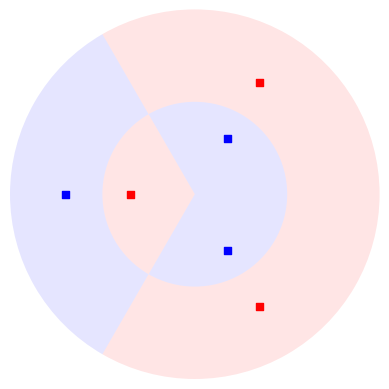

In [4]:
import matplotlib.pyplot as plt

num_sectors = 3
X, Y = make_double_cake_data(num_sectors)

ax = plot_double_cake_data(X, Y, plt.gca(), num_sectors=num_sectors)


In [8]:
import pennylane as qml


def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])
    
def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))


adjoint_ansatz = qml.adjoint(ansatz)


def random_params(num_wires, num_layers):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires), requires_grad=True)


dev = qml.device("default.qubit", wires=5, shots=None)
wires = dev.wires.tolist()


@qml.qnode(dev)
def kernel_circuit(x1, x2, params):
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(x2, params, wires=wires)
    return qml.probs(wires=wires)

def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)[0]




In [9]:
init_params = random_params(num_wires=5, num_layers=6)

In [10]:
kernel_value = kernel(X[0], X[1], init_params)
print(f"The kernel value between the first and second datapoint is {kernel_value:.3f}")


The kernel value between the first and second datapoint is 0.030


In [42]:
from utils.classification_data import checkerboard_data, linear_data, hidden_manifold_data, power_line_data, microgrid_data
from sklearn.model_selection import train_test_split
data = checkerboard_data(5, 100)
data

,feature_1,feature_2,feature_3,target
0,439.696098,19.413507,-346.143990,1
1,301.383044,-57.311965,-376.260670,-1
2,430.294184,-354.869263,298.677702,-1
3,284.805397,238.235096,-385.805970,1
4,19.287708,153.283479,-14.750879,1
5,479.643035,154.173968,319.246503,-1
6,-246.038547,452.936892,-77.778271,-1
7,224.898409,243.624809,133.921752,-1
8,-88.257300,-95.365191,-108.997893,-1
9,423.726271,-411.643972,440.629865,-1


In [43]:
features = np.asarray(data[[col for col in data.columns if col != 'target']].values.tolist())
target = np.asarray(data['target'].values.tolist())
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [44]:
kernel_value = kernel(x_train[0], x_train[5], init_params)
print(f"The kernel value between the first and second datapoint is {kernel_value:.3f}")

The kernel value between the first and second datapoint is 0.051


In [45]:
init_kernel = lambda x1, x2: kernel(x1, x2, init_params)
K_init = qml.kernels.square_kernel_matrix(x_train, init_kernel, assume_normalized_kernel=True)

with np.printoptions(precision=3, suppress=True):
    print(K_init)

[[1.    0.001 0.028 ... 0.    0.    0.003]
 [0.001 1.    0.071 ... 0.061 0.075 0.003]
 [0.028 0.071 1.    ... 0.017 0.086 0.042]
 ...
 [0.    0.061 0.017 ... 1.    0.03  0.007]
 [0.    0.075 0.086 ... 0.03  1.    0.009]
 [0.003 0.003 0.042 ... 0.007 0.009 1.   ]]


In [46]:
from sklearn.svm import SVC
svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(x_train, y_train)

In [47]:
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)


accuracy_init = accuracy(svm, x_train, y_train)
print(f"The accuracy of the kernel with random parameters is {accuracy_init:.3f}")


The accuracy of the kernel with random parameters is 1.000


In [48]:
accuracy_init = accuracy(svm, x_test, y_test)
print(f"The accuracy of the kernel with random parameters is {accuracy_init:.3f}")

The accuracy of the kernel with random parameters is 0.500


In [49]:
def plot_decision_boundaries(classifier, ax, N_gridpoints=14):
    _xx, _yy = np.meshgrid(np.linspace(-1, 1, N_gridpoints), np.linspace(-1, 1, N_gridpoints))

    _zz = np.zeros_like(_xx)
    for idx in np.ndindex(*_xx.shape):
        _zz[idx] = classifier.predict(np.array([_xx[idx], _yy[idx]])[np.newaxis, :])

    plot_data = {"_xx": _xx, "_yy": _yy, "_zz": _zz}
    ax.contourf(
        _xx,
        _yy,
        _zz,
        cmap=mpl.colors.ListedColormap(["#FF0000", "#0000FF"]),
        alpha=0.2,
        levels=[-1, 0, 1],
    )
    plot_double_cake_data(X, Y, ax)

    return plot_data


In [50]:
kta_init = qml.kernels.target_alignment(x_train, y_train, init_kernel, assume_normalized_kernel=True)
print(f"The kernel-target alignment for our dataset and random parameters is {kta_init:.3f}")

The kernel-target alignment for our dataset and random parameters is 0.146


In [51]:
def target_alignment(
    X,
    Y,
    kernel,
    assume_normalized_kernel=False,
    rescale_class_labels=True,
):
    """Kernel-target alignment between kernel and labels."""

    K = qml.kernels.square_kernel_matrix(
        X,
        kernel,
        assume_normalized_kernel=assume_normalized_kernel,
    )

    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product


params = init_params
opt = qml.GradientDescentOptimizer(0.2)

for i in range(500):
    # Choose subset of datapoints to compute the KTA on.
    subset = np.random.choice(list(range(len(x_train))), 4)
    # Define the cost function for optimization
    cost = lambda _params: -target_alignment(
        x_train[subset],
        y_train[subset],
        lambda x1, x2: kernel(x1, x2, _params),
        assume_normalized_kernel=True,
    )
    # Optimization step
    params = opt.step(cost, params)

    # Report the alignment on the full dataset every 50 steps.
    if (i + 1) % 50 == 0:
        current_alignment = target_alignment(
            x_train,
            y_train,
            lambda x1, x2: kernel(x1, x2, params),
            assume_normalized_kernel=True,
        )
        print(f"Step {i+1} - Alignment = {current_alignment:.3f}")


Step 50 - Alignment = 0.148
Step 100 - Alignment = 0.152
Step 150 - Alignment = 0.154
Step 200 - Alignment = 0.156
Step 250 - Alignment = 0.159
Step 300 - Alignment = 0.161
Step 350 - Alignment = 0.162
Step 400 - Alignment = 0.163
Step 450 - Alignment = 0.164
Step 500 - Alignment = 0.164


In [52]:
# First create a kernel with the trained parameter baked into it.
trained_kernel = lambda x1, x2: kernel(x1, x2, params)
# Second create a kernel matrix function using the trained kernel.
trained_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, trained_kernel)
# Note that SVC expects the kernel argument to be a kernel matrix function.
svm_trained = SVC(kernel=trained_kernel_matrix).fit(x_train, y_train)

In [53]:
accuracy_trained = accuracy(svm_trained, x_train, y_train)
print(f"The accuracy of a kernel with trained parameters is {accuracy_trained:.3f}")

The accuracy of a kernel with trained parameters is 1.000


In [55]:
accuracy_trained = accuracy(svm_trained, x_test, y_test)
print(f"The accuracy of a kernel with trained parameters is {accuracy_trained:.3f}")

The accuracy of a kernel with trained parameters is 0.600
